- [jupyter 支持](jupyter.ipynb)
    - [分段执行和上下文](#分段执行和上下文)
    - [查看变量值](#查看变量值)
    - [绘图支持](#绘图支持)
    - [magic 支持](#magic-支持)
    - [python 交叉编程支持](#python-交叉编程支持)
- [**⟶ 目录**](contents.md)

# jupyter 支持

jse 从 `2.7.0` 开始支持作为内核直接在 jupyter 中使用（不需要通过 py4j），
从而实现分段执行 groovy 代码以及 python 代码，并支持将绘图结果输出到 jupyter。

> jse 内部基于 [SpencerPark/jupyter-jvm-basekernel](https://github.com/SpencerPark/jupyter-jvm-basekernel)
> 实现了自定义的 jupyter 内核构建，而此包通过 [jeromq](https://github.com/zeromq/jeromq)
> 来实现 jupyter 和内核之间的通讯，并使用 [gson](https://github.com/google/gson)
> 来实现 json 数据的解析和编码。
>
> jse 将这些库全都包含到了 `jse-all.jar` 中来保证功能完整，
> 当然因此用户也可以使用 jeromq 以及 gson。
> 

当然要求用户拥有 python 环境以及 jupyter 环境（直接安装完整的 Anaconda 或者通过
`pip3 install jupyter`），然后参考 [基本使用方法中通过 jupyter 使用](usage.md#通过-jupyter-使用)
或者 [命令行参数中的 -jupyter](commandline.md#jupyter) 来将 jse 内核安装到 jupyter 中：

```shell
jse -jupyter
```

输出

```
The jupyter kernel for JSE has been initialized,
now you can open the jupyter notebook through `jupyter notebook`
```

表示安装成功。

## 分段执行和上下文

jse 内核默认会将代码块当作 groovy 脚本执行，并将最后一句的输出显式到
jupyter 上：

In [1]:
a = 10
int b = 20
def c = 30 // this line will output, the assignment statement in groovy will also have the output

30

在 groovy 中创建变量时，如果带有前缀 `def` 或 `int` 之类的变量类型，
groovy 会将其当作一个局部变量，而不会存入上下文（`context` / `binding`），
因此在另一个代码块中不能访问。

相对的，没有前缀的变量则会存入上下文，使得可以在另一个代码块中继续访问：

In [2]:
println(a)
a += 10
println(a)
println(b) // <- will get exception here
println(c)

10
20


MissingPropertyException: No such property: b for class: ScriptJSE2

和 python 不同，groovy 中所有的导入都是临时的，
因此这里每个代码块的导入（import）都是独立的，
上一个代码块的导入不能在下一个代码块中使用。

> shell 模式下运行（[groovysh](https://groovy-lang.org/groovysh.html)）
> 中提供了全局的导入（import）支持，实际是在代码执行之前，
> 拦截了所有的 `import` 指令，并将所有的导入存储起来，
> 在实际代码运行时再将存储的导入加回去，从而模拟全局导入。
>
> 在这里没有必要这样做，因此保留原本的独立导入逻辑。
> 

In [3]:
import static jse.code.CS.VERSION

println(VERSION)

2.7.6b


In [4]:
println(VERSION) // <- no property `VERSION`, because the import has been lost

MissingPropertyException: No such property: VERSION for class: ScriptJSE4

## 查看变量值

除了使用 `println()` 或者直接将变量放在最后一行的方式，
jse 通过实现 jupyter 中的 `inspect` 接口来查看变量，
具体操作为：

- 将光标选中到需要查看的变量位置 `a| += 10` / `|a += 10`

- 使用快捷键 `shift + tab`，即可查看到此变量在内存中的值

> 注意：vscode 似乎并不支持 `inspect` 操作，而只支持通用的 jupyter 变量视图，
> 这部分基于 [jupyter 的 DAP](https://jupyter-client.readthedocs.io/en/stable/messaging.html#inspectvariables)
> ，而 jupyter-jvm-basekernel 暂时不支持这个，因此暂时不能通过这种方法来查看变量值。
>
> jupyter-jvm-basekernel 的作者似乎正在 [积极对 DAP 提供支持](https://github.com/SpencerPark/jupyter-jvm-basekernel/pull/33)
> ，在正式提供支持后 jse 也会跟进。
> 

## 绘图支持

默认情况下，jse 会自动检测到为在 jupyter 内核中运行，
并将所有的绘图结果输出到 jupyter 中，而不会创建窗口。

> 这里逻辑和原本绘图保持一致，通过 `jse.code.UT.Plot`
> 中的函数绘制只会绘制一张图，且自动执行 `show()` 操作，
> 而绘制多张图需要通过 `jse.plot.Plotters`
> 中的 `get()` 方法获取到多个 `Plotter` 然后分别绘制，
> 此时需要手动执行 `show()` 才会进行显示。

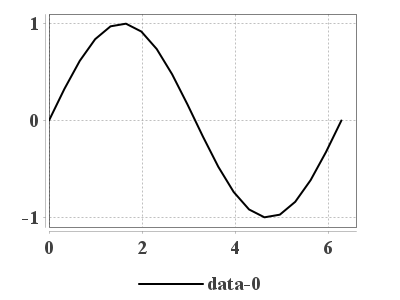

In [5]:
// single figure
import static jse.code.UT.Plot.*
import static jse.code.UT.Math.*

def x = linspace(0, 2.0*pi, 20)
def y = sin(x)

cla()
plot(x, y)
figsize(400, 300)

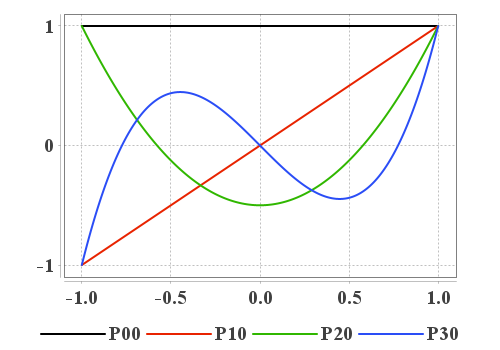

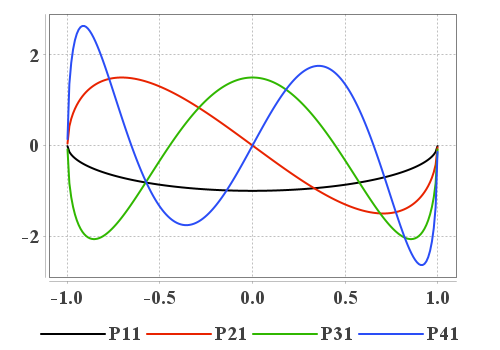

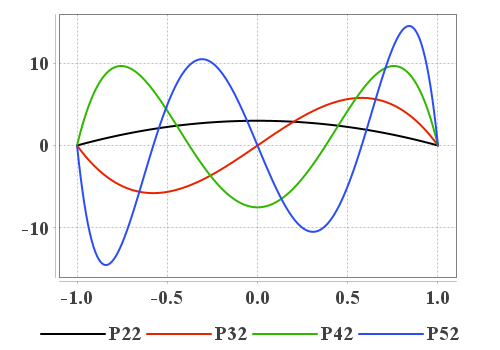

In [6]:
// multiple figures
import jse.plot.Plotters
import static jse.code.UT.Math.*

def x = linspace(-0.9999, 0.9999, 200)

def P00 = legendre(0, 0, x)
def P10 = legendre(1, 0, x)
def P20 = legendre(2, 0, x)
def P30 = legendre(3, 0, x)

def P11 = legendre(1, 1, x)
def P21 = legendre(2, 1, x)
def P31 = legendre(3, 1, x)
def P41 = legendre(4, 1, x)

def P22 = legendre(2, 2, x)
def P32 = legendre(3, 2, x)
def P42 = legendre(4, 2, x)
def P52 = legendre(5, 2, x)

def plt1 = Plotters.get()
plt1.plot(x, P00, 'P00')
plt1.plot(x, P10, 'P10')
plt1.plot(x, P20, 'P20')
plt1.plot(x, P30, 'P30')
plt1.size(500, 350)
plt1.show()

def plt2 = Plotters.get()
plt2.plot(x, P11, 'P11')
plt2.plot(x, P21, 'P21')
plt2.plot(x, P31, 'P31')
plt2.plot(x, P41, 'P41')
plt2.size(500, 350)
plt2.show()

def plt3 = Plotters.get()
plt3.plot(x, P22, 'P22')
plt3.plot(x, P32, 'P32')
plt3.plot(x, P42, 'P42')
plt3.plot(x, P52, 'P52')
plt3.size(500, 350)
plt3.show()

## magic 支持

jse 支持使用一些 magic 指令来实现特殊操作，
通过 `%lsmagic` 来查看所有支持的 magic：

In [7]:
%lsmagic

Available line magics:
%lsmagic

Available cell magics:
%%python  %%groovy  %%writefile

- **`%%python`**：
    
    将当前代码块当作 python 脚本执行，
    底层会基于 jep 执行此代码块，因此可以直接导入 java 以及 jse
    的包，具体可以参考 [基本使用方法中通过 jep 使用 jse](usage.md#b-通过-jep-使用-jse)。

In [8]:
%%python
print('hello world')
for i in range(5):
    print(i)

hello world
0
1
2
3
4


- **`%%writefile`**：
    
    将当前代码块写入到指定的文件中。

In [9]:
%%writefile .temp/hello.groovy
println('hello groovy')

Cell body has been written to '.temp/hello.groovy' (g:\CHanzy\project\CSRC-jTool\doc\.temp\hello.groovy)

In [10]:
import jse.code.SP

SP.Groovy.run('.temp/hello.groovy')

hello groovy


- **`%%groovy`**：
    
    将当前代码块当作 groovy 脚本执行，
    这是默认的行为，因此一般会省略；
    添加此 magic 主要在 python 和 groovy
    同时使用时帮助阅读，或者标明此 `.ipynb`
    需要使用 jse 的内核执行，而不是一般的 python 内核。

## python 交叉编程支持

通过在代码块上使用 cell magic `%%python`
即可使用内部的 jep 来运行此代码块，从而实现和 python
的较差编程。

需要注意的是，由于是通过 jep 运行的，和一般的 python
存在一些区别：

-   由于 jep 的限制，不能获取到最后一行的输出：

In [11]:
%%python
a = 11
a # no output 

In [12]:
%%python
print(a)

11


-   变量不会和 groovy 中的变量直接同步，
    如果需要使用则需要通过 `jse.code.SP`
    中的方法来获取：

In [13]:
a  // <- a is still 20 from `a = 10` and `a += 10`

20

In [14]:
import jse.code.SP

println(SP.Python.get('a')) // use `SP.Python.get` to get python varible

11


-   jse 中也对 python 的 matplotlib 中提供了支持，
    由于不是原生的支持，因此行为会有部分不同。
    
    这里通过直接将 matplotlib 的后端设为 `Agg`
    来关闭窗口输出，然后在每次代码块执行完成后检测所有的图片，
    然后遍历将其输出，并清空内部的所有图片。
    
    因此：
    
    - 在绘制完成后同样不需要调用 `show()`（并且调用时会警告）
    - 绘制多个图片时需要通过 `figure()` 来创建新的图片：
    - 代码块执行完成后会清空所有的 matplotlib 图片（jse 中的绘图则不会）

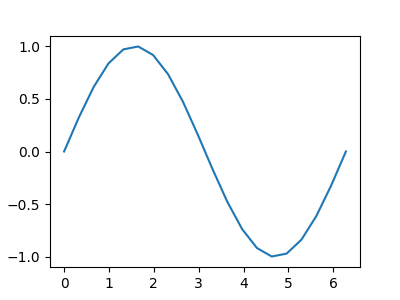

In [15]:
%%python
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.0, 2.0*np.pi, 20)
y = np.sin(x)

plt.figure(figsize=(4, 3))
plt.plot(x, y)

-   python 和 jse 相互调用绘图时，图片也能正常渲染：

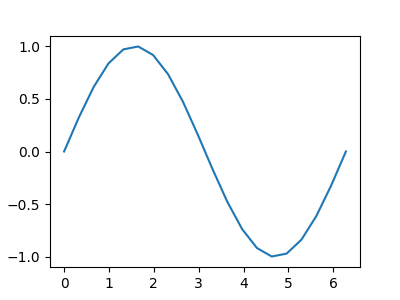

[Line2D(_child0)]

In [16]:
// jse invoke python
import jse.code.SP

SP.Python.exec('import numpy as np')
SP.Python.exec('import matplotlib.pyplot as plt')
np = SP.Python.getClass('np')
plt = SP.Python.getClass('plt')

x = np.linspace(0.0, 2.0*np.pi, 20)
y = np.sin(x)

plt.figure(figsize: [4, 3])
plt.plot(x, y)

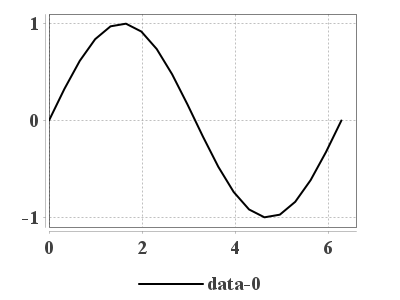

In [17]:
%%python
# python invoke jse
from jse.compat.UT import Math as nj
from jse.compat.UT import Plot as jlt

x = nj.linspace(0, 2.0*nj.pi, 20)
y = nj.sin(x)

jlt.cla()
jlt.plot(x, y)
jlt.figsize(400, 300)